In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import create_KS_data, compute_lyapunov_spectrum

In [8]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

FTYPE = np.float64
ITYPE = np.int64

In [9]:
tf.test.gpu_device_name()

''

# KS System

In [10]:
# setting up params (and saving, if applicable)
params_mat = np.array([
    [1.0, 1.0, 1.0],
    [2.0, 1.0, 1.0],
    [1.0, 2.0, 1.0],
    # [1.0, 1.0, 2.0]
], dtype=FTYPE)
num_cases = params_mat.shape[0]

t0 = 0.0
T = 220.0
delta_t = 0.1

return_params_arr = False
normalize_flag = False
alldata_withparams_flag = True

numpoints_xgrid = 64
length = 40
xgrid = length*np.linspace(0, 1, numpoints_xgrid, dtype=FTYPE)

init_state = np.sin(5*np.pi*xgrid/xgrid[-1], dtype=FTYPE)

### Creating initial data, for transient inspection and cutoff

In [11]:
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag, FTYPE=FTYPE, ITYPE=ITYPE
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [12]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

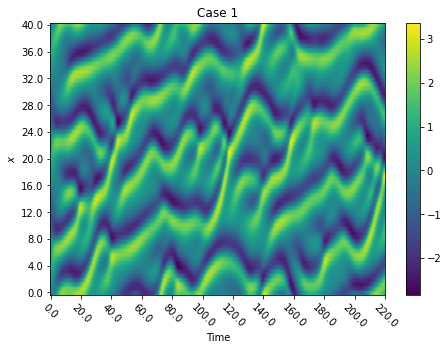

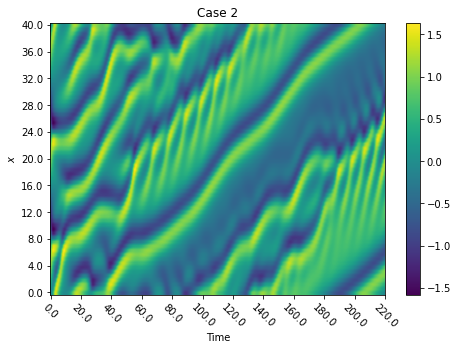

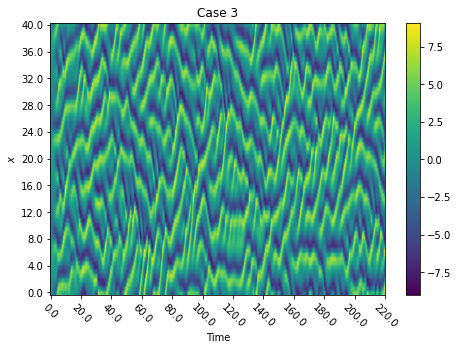

In [13]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [14]:
# making relevant helper arrays to cut off initial transient
initial_t0 = np.array([
    20,
    20,
    20,
    # 20
], dtype=FTYPE) # try to keep all entries the same
initial_idx = np.zeros_like(initial_t0, dtype=ITYPE)

begin_idx = 0
len_relevant_idx = 0
for i in range(len(initial_t0)):
    init_idx = ITYPE( (initial_t0[i] + 0.5*delta_t)//delta_t )
    initial_idx[i] = init_idx + begin_idx
    len_relevant_idx += boundary_idx_arr[i] - initial_idx[i]
    begin_idx = boundary_idx_arr[i]

relevant_idx = np.empty(shape=len_relevant_idx, dtype=ITYPE)
start = 0
for i in range(len(initial_t0)):
    end = start + (boundary_idx_arr[i] - initial_idx[i])
    relevant_idx[start:end] = np.arange(initial_idx[i], boundary_idx_arr[i])
    start = end

In [15]:
print('boundary_idx_arr :', boundary_idx_arr)
print('initial_idx :', initial_idx)

boundary_idx_arr : [2201 4402 6603]
initial_idx : [ 200 2401 4602]


In [16]:
# cutting off initial transient
all_data = all_data[relevant_idx]
# init_idx = 0
# for i in range(len(boundary_idx_arr)):
#     init_idx += (initial_t0[i] + 0.25*delta_t)//delta_t
#     boundary_idx_arr[i] -= init_idx

prev_boundary_idx = 0
for i in range(num_cases):
    boundary_idx_arr[i] = prev_boundary_idx + (boundary_idx_arr[i] - initial_idx[i])
    prev_boundary_idx = boundary_idx_arr[i]

In [17]:
boundary_idx_arr

array([2001, 4002, 6003])

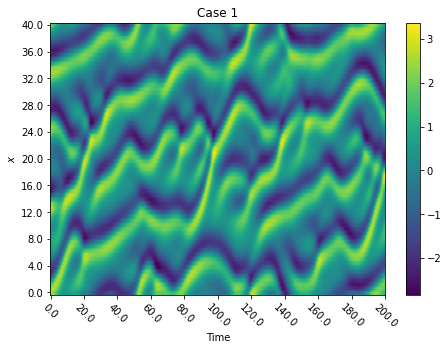

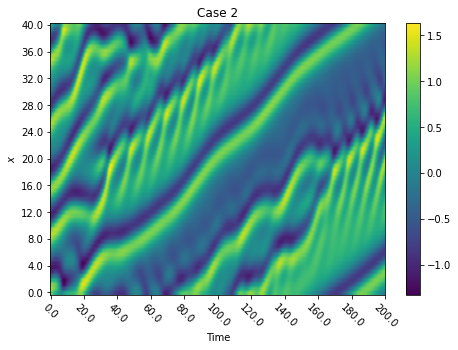

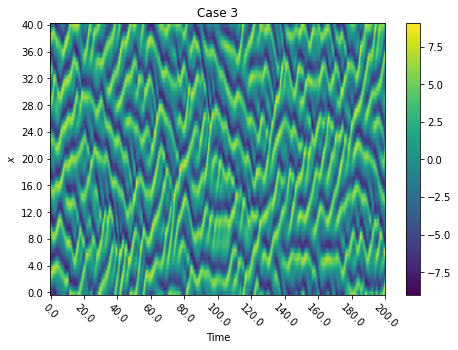

In [18]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

### Computing the Lyapunov spectrum

In [19]:
cdf_kwargs = {
    'T':1000,
    't0':0,
    'delta_t':delta_t,
    'xgrid':xgrid,
    'return_params_arr':False,
    'normalize':False,
    'alldata_withparams':False,
    'FTYPE':np.float64,
    'ITYPE':np.int64
}

create_data_fn = create_KS_data
num_modes = xgrid.shape[0]

init_state_mat = np.empty(shape=(num_cases, num_modes), dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    init_state_mat[i, :] = all_data[begin_idx, 0:num_modes]
    begin_idx = boundary_idx_arr[i]

dy = 1e-9
dy_mat = np.empty(shape=num_cases, dtype=FTYPE)
begin_idx = 0
for i in range(num_cases):
    # dy_mat[i] = dy * np.mean(  np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i]], axis=1 )/xgrid.shape[0]  ) timeMean of spaceMeanofSpaceNorm
    dy_mat[i] = dy * np.mean( np.linalg.norm( all_data[begin_idx:boundary_idx_arr[i], 0:num_modes], axis=0 )/( (boundary_idx_arr[i]-begin_idx)**0.5 ) ) # spaceMean of timeRMS
    begin_idx = boundary_idx_arr[i]
    print('dy_mat[{}] :'.format(i), dy_mat[i])
print('')

lpspectrum_mat, _ = compute_lyapunov_spectrum(
    create_data_fn, cdf_kwargs, num_modes, 
    init_state_mat, params_mat, dy_mat,
    zeta=10, delta_completionratio=0.1, num_exp=None, print_flag=True)

dy_mat[0] : 1.2941188414627263e-09
dy_mat[1] : 6.274890994559579e-10
dy_mat[2] : 3.7077690270846387e-09

number of evaluation intervals per case: 1000

case 1 completion_ratio : 0.1, elapsed_time : 27.413s, global_completion : 3.333%
case 1 completion_ratio : 0.2, elapsed_time : 53.83s, global_completion : 6.667%
case 1 completion_ratio : 0.3, elapsed_time : 80.409s, global_completion : 10.0%
case 1 completion_ratio : 0.4, elapsed_time : 107.543s, global_completion : 13.333%
case 1 completion_ratio : 0.5, elapsed_time : 134.128s, global_completion : 16.667%
case 1 completion_ratio : 0.6, elapsed_time : 160.583s, global_completion : 20.0%
case 1 completion_ratio : 0.7, elapsed_time : 187.059s, global_completion : 23.333%
case 1 completion_ratio : 0.8, elapsed_time : 213.424s, global_completion : 26.667%
case 1 completion_ratio : 0.9, elapsed_time : 239.796s, global_completion : 30.0%
case 1 completion_ratio : 1.0, elapsed_time : 266.153s, global_completion : 33.333%
case 1 MLE : 0.07866

In [20]:
lpspectrum_mat.sort(axis=1)
lpspectrum_mat = lpspectrum_mat[:, -1::-1]

In [21]:
print(lpspectrum_mat[:, 0])

[0.07866302 0.02739004 0.23850006]


### Computing new data based on 'initial states' from the transient cutoffs and total time from mean Lyapunov time

In [22]:
# re-creating data according to mean lyapunov time
mean_lyaptime = np.mean(lpspectrum_mat[:, 0]**(-1))
total_lyaptimesteps_totrain = 100#(800+0.1*mean_lyaptime)//mean_lyaptime
T = total_lyaptimesteps_totrain*mean_lyaptime

# cleaning up
del(all_data)
del(boundary_idx_arr)
del(params_arr)
del(normalization_constant_arr)
del(res_dict)

# creating new data
res_dict = create_KS_data(
    T, t0, delta_t, xgrid,
    init_state_mat, params_mat,
    return_params_arr=return_params_arr,
    normalize=normalize_flag,
    alldata_withparams=alldata_withparams_flag, FTYPE=FTYPE, ITYPE=ITYPE
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [23]:
# making ae save directory
dir_name_data = os.getcwd() + dir_sep + 'saved_data'
if not os.path.isdir(dir_name_data):
    os.makedirs(dir_name_data)

counter = 0
while True:
    dir_check = 'data_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_data + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_data = dir_name_data + dir_sep + dir_check
os.makedirs(dir_name_data)
print('dir_name_data:', dir_name_data)

# saving sim data
sim_data = {
    'params_mat':params_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'numpoints_xgrid':numpoints_xgrid,
    'length':length,
    'return_params_arr':return_params_arr,
    'normalize_flag':normalize_flag,
    'alldata_withparams_flag':alldata_withparams_flag,
    'prng_seed':prng_seed,
    'total_lyaptimesteps_totrain':total_lyaptimesteps_totrain
}
with open(dir_name_data+dir_sep+'sim_data_params.txt', 'w') as f:
    f.write(str(sim_data))

dir_name_data: /content/drive/MyDrive/Github/MLROM/KS/saved_data/data_003


In [24]:
# saving the data
np.savez(
    dir_name_data+dir_sep+'data',
    all_data=all_data,
    boundary_idx_arr=boundary_idx_arr,
    normalization_constant_arr=[normalization_constant_arr],
    initial_t0=initial_t0,
    init_state_org=init_state,
    init_state_mat=init_state_mat,
    lyapunov_spectrum_mat=lpspectrum_mat,
    )

In [25]:
# plotting the data and saving the plots
dir_plot = dir_name_data+dir_sep+'plots'
os.makedirs(dir_plot)

roundtomultipleof = 40
xticks_snapto = int(40*np.round((T/10)/40, 0))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_dir=dir_plot,
    xlabel=r'Time',
    ylabel=r'$x$',
    ax_titles_list=None
)

In [26]:
fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)

In [27]:
fl.files

['all_data',
 'boundary_idx_arr',
 'normalization_constant_arr',
 'initial_t0',
 'init_state_org',
 'init_state_mat',
 'lyapunov_spectrum_mat']